In [455]:
##################### data preprocessing #####################

# # install packages
# !pip install baostock

# import packages
import math
import numpy as np
import pandas as pd
import baostock as bs
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# download CSI dataset
lg = bs.login()

fields= "date,open,high,low,close"
rs = bs.query_history_k_data("sh.000001", fields, start_date="1992-01-01", end_date="2024-1-31", frequency="d", adjustflag="2")
data_list = []
while (rs.error_code == "0") & rs.next():
    data_list.append(rs.get_row_data())
df = pd.DataFrame(data_list, columns=rs.fields)
df.index=pd.to_datetime(df.date)

bs.logout()

# check dataset
# df.info()



# create the dataset only containing close prices
data = pd.DataFrame(pd.to_numeric(df["close"]))
dataset = np.reshape(data.values, (df.shape[0], 1))

# # normalise the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# define a function to get training and test data
def split_data(dataset, train_day, predict_day):
    x = []
    y = []
    for i in range(train_day, len(dataset)-predict_day+1):
        x.append(dataset[i-train_day : i, 0])
        y.append(dataset[i+predict_day-1, 0])
    return x, y

# x => data from previous days; y => data in the next day
def reshape_data(train_data, test_data, days):
    x_train, y_train = split_data(train_data, days, 1)
    x_test, y_test = split_data(test_data, days, 1)
    # convert data into numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)
    # reshape the data for neural network training
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    return x_train, y_train, x_test, y_test

# create the scaled training data set
training_data_len = math.ceil(len(dataset) * 0.95)
train_data = scaled_data[0:training_data_len, :]
# print(data[:train_data.shape[0]].tail())

# create the scaled test data set
test_data = scaled_data[training_data_len-5: , :]

# use 5 consecutive trading days as the unit step size sliding through the stock price data
x_train_5, y_train_5, x_test_5, y_test_5 = reshape_data(train_data, test_data, 5)
print("when sequence length is 5, data shape:", x_train_5.shape, y_train_5.shape, x_test_5.shape, y_test_5.shape)


login success!
logout success!
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7824 entries, 1992-01-02 to 2024-01-25
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    7824 non-null   object
 1   open    7824 non-null   object
 2   high    7824 non-null   object
 3   low     7824 non-null   object
 4   close   7824 non-null   object
dtypes: object(5)
memory usage: 366.8+ KB
                close
date                 
2023-06-02  3230.0686
2023-06-05  3232.4410
2023-06-06  3195.3404
2023-06-07  3197.7587
2023-06-08  3213.5855
when sequence length is 5, data shape: (7663, 1, 5) (7663,) (156, 1, 5) (156,)


In [456]:
##################### model definition #####################

# import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from torch.optim.lr_scheduler import ReduceLROnPlateau

# initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_input = 5; n_hidden = 64; weight_strength = 1e-3
# torch.manual_seed(42)

#calculate the weight of previous days
rf = RandomForestRegressor(n_estimators=100,random_state=42)
rf.fit(x_train_5.reshape(-1,5),y_train_5)
weight = rf.feature_importances_

#normalize the weight
weight_mean = np.mean(weight)
weight_std = np.std(weight)
weight = ((weight - weight_mean)/weight_std) + 1
weight = weight/np.sum(weight)
# scaler = MinMaxScaler()
# weight = scaler.fit_transform(weight.reshape(-1,1))
print(weight,weight_std,weight_mean)


[0.09985224 0.09982992 0.09983243 0.10048572 0.59999969] 0.3988148666047591 0.2


In [457]:
class ResNLS(nn.Module):

    def __init__(self,weight):
        super(ResNLS, self).__init__()

        # intialise weights of the attention mechanism
        self.weight = torch.tensor(weight_strength * weight, dtype=torch.float).to(device)

        # intialise cnn structure
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=n_hidden, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(n_hidden, eps=1e-5),
            nn.Dropout(0.2),

            nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(n_hidden, eps=1e-5),
            nn.Dropout(0.2),

            nn.Flatten(),
            nn.Linear(n_input * n_hidden, n_input)
        )

        # intialise lstm structure
        self.lstm = nn.LSTM(n_input, 32, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(32, 1)


    def forward(self, x):

        cnn_output = self.cnn(x)
        cnn_output = cnn_output.view(-1, 1, n_input)

        x = x.view(-1, 1, n_input)
        residuals = x + cnn_output * self.weight 
        
        # print('x')
        # print(x)
        # print('weight')
        # print(self.weight)
        # print('cnn_output')
        # print(cnn_output)
        # print('cnn_output.shape')
        # print(cnn_output.shape)
        _, (h_n, _)  = self.lstm(residuals)
        y_hat = self.linear(h_n[0,:,:])

        return y_hat



Epoch:   1, train loss: 0.0001, val loss: 0.0007
Epoch:   2, train loss: 0.0001, val loss: 0.0007
Epoch:   3, train loss: 0.0001, val loss: 0.0008
Epoch:   4, train loss: 0.0001, val loss: 0.0008
Epoch:   5, train loss: 0.0001, val loss: 0.0008
Epoch:   6, train loss: 0.0001, val loss: 0.0008
Epoch:   7, train loss: 0.0001, val loss: 0.0008
Epoch:   8, train loss: 0.0001, val loss: 0.0008
Epoch:   9, train loss: 0.0001, val loss: 0.0008
Epoch:  10, train loss: 0.0001, val loss: 0.0008
Epoch:  11, train loss: 0.0001, val loss: 0.0008
Epoch:  12, train loss: 0.0001, val loss: 0.0008
Epoch:  13, train loss: 0.0001, val loss: 0.0008
Epoch:  14, train loss: 0.0001, val loss: 0.0008
Epoch:  15, train loss: 0.0001, val loss: 0.0008
Epoch:  16, train loss: 0.0001, val loss: 0.0008
Epoch:  17, train loss: 0.0001, val loss: 0.0008
Epoch:  18, train loss: 0.0001, val loss: 0.0008
Epoch:  19, train loss: 0.0001, val loss: 0.0008
Epoch:  20, train loss: 0.0001, val loss: 0.0008
Epoch:  21, train lo

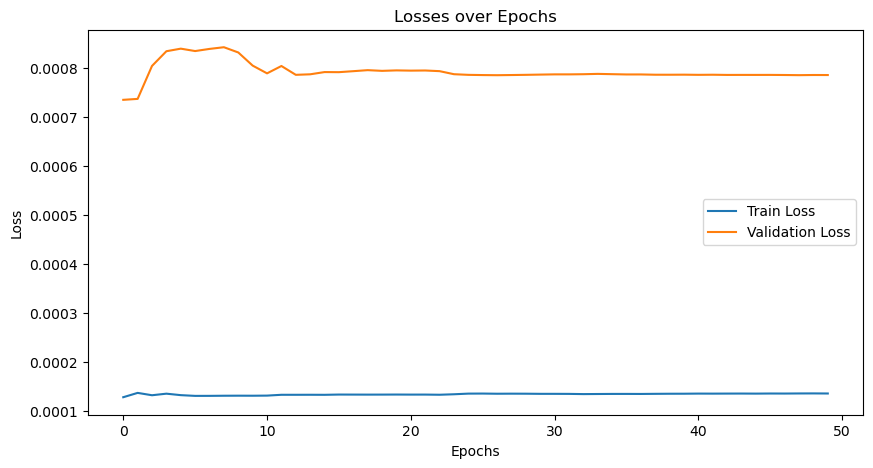

In [458]:
##################### model training #####################

import matplotlib.pyplot as plt

# prepare validation data
val_input = torch.tensor(x_test_5, dtype=torch.float).to(device)
val_target = torch.tensor(y_test_5, dtype=torch.float).to(device)

# initialization
epochs = 50; batch_size = 64

# model instance
model = ResNLS(weight).to(device)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# mini-batch training
if x_train_5.shape[0] % batch_size == 0:
    batch_num = int(x_train_5.shape[0] / batch_size)
else:
    batch_num = int(x_train_5.shape[0] / batch_size) + 1

# lists to store loss values
train_losses = []
val_losses = []

for epoch in range(epochs):
    for j in range(batch_num):

        # prepare training data
        train_input = torch.tensor(x_train_5[j * batch_size : (j+1) * batch_size], dtype=torch.float).to(device)
        train_targe = torch.tensor(y_train_5[j * batch_size : (j+1) * batch_size], dtype=torch.float).to(device)

        # training
        model.train()
        optimizer.zero_grad()
        train_output = model(train_input)
        train_loss = criterion(train_output, train_targe)
        train_loss.backward()
        optimizer.step()

    # if (epoch+1) % (epochs/20) == 0:
    with torch.no_grad():
        model.eval()
        val_output = model(val_input)
        val_loss = criterion(val_output, val_target)
        print("Epoch: {:>3}, train loss: {:.4f}, val loss: {:.4f}".format(epoch+1, train_loss.item(), val_loss.item()))
        
        # append losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
    scheduler.step(val_loss)

# plot the losses
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [459]:
##################### model validation #####################

# import packages
from sklearn import metrics

# get the model predicted price values
predictions = model(val_input)
predictions = scaler.inverse_transform(predictions.cpu().detach().numpy())
# plot the stock price
train = data[:training_data_len]
valid = data[training_data_len:]
valid["predictions"] = predictions

# calculate MSE
y = np.array(valid["close"])
y_hat = np.array(valid["predictions"])
mae = metrics.mean_absolute_error(y_hat, y)
mse = metrics.mean_squared_error(y_hat, y)
rmse = metrics.mean_squared_error(y_hat, y) ** 0.5
print("MAE:{:.2F}   MSE: {:.2f}   RMSE:{:.2F}".format(mae, mse, rmse))


MAE:29.26   MSE: 1430.58   RMSE:37.82


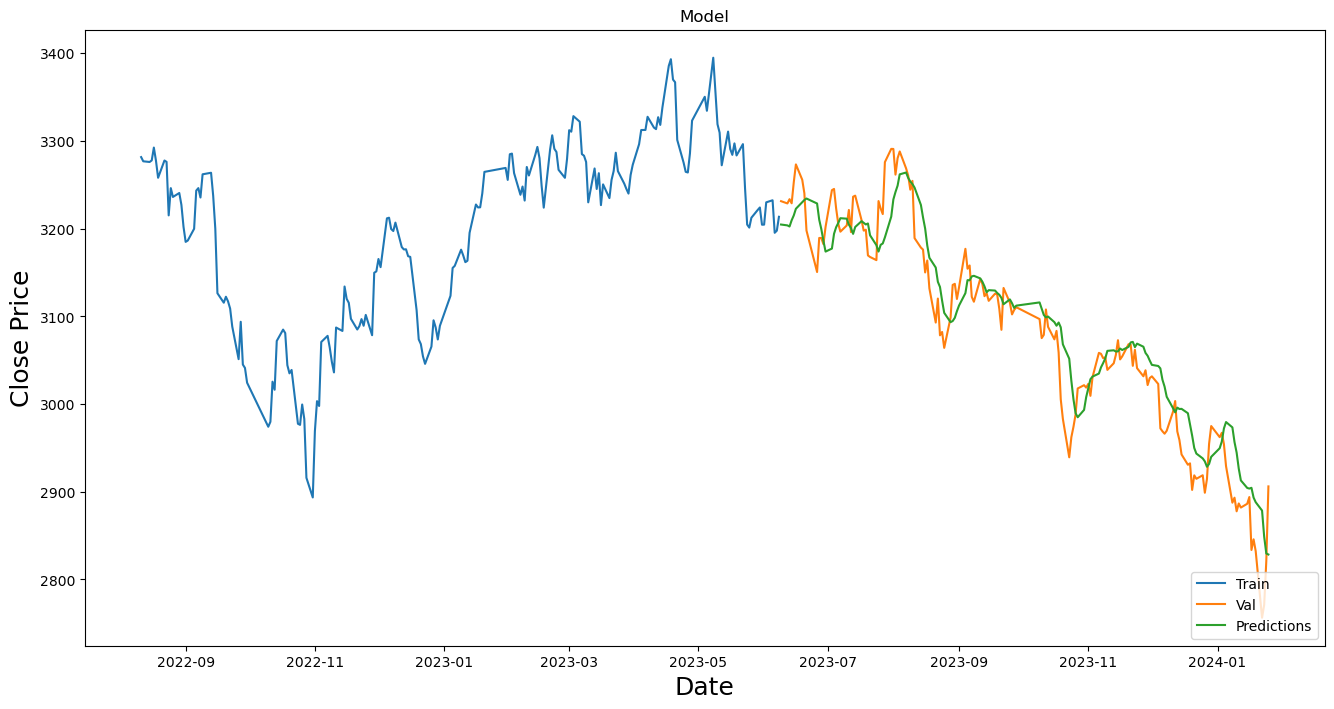

In [460]:
# plot the results
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['close'][-200:])
plt.plot(valid[['close', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
